In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import probplot
from scipy.stats import zscore

In [3]:
df=pd.read_csv(r"C:\Users\Asus\Downloads\MiniProject\water_dataX.csv",encoding= 'unicode_escape')
df.shape

(1991, 12)

In [4]:
df=df.iloc[0:1900,:]
df.shape

(1900, 12)

In [5]:
df.dtypes

STATION CODE                        object
LOCATIONS                           object
STATE                               object
Temp                                object
D.O. (mg/l)                         object
PH                                  object
CONDUCTIVITY (µmhos/cm)             object
B.O.D. (mg/l)                       object
NITRATENAN N+ NITRITENANN (mg/l)    object
FECAL COLIFORM (MPN/100ml)          object
TOTAL COLIFORM (MPN/100ml)Mean      object
year                                 int64
dtype: object

In [6]:
df.head()

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


In [7]:
df = df.rename(columns={"D.O. (mg/l)": "DO", "CONDUCTIVITY (µmhos/cm)": "Conductivity", "B.O.D. (mg/l)": "BOD", "NITRATENAN N+ NITRITENANN (mg/l)": "NI", "FECAL COLIFORM (MPN/100ml)": "Fec_col", "TOTAL COLIFORM (MPN/100ml)Mean": "Tot_col"})

In [8]:
def convert_to_numeric(df):
    num_col = df.shape[1]
    # Start from index 3
    for index in range(3, num_col):
        col_name = df.iloc[:, index].name
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
    return df

df = convert_to_numeric(df)
df.dtypes

STATION CODE     object
LOCATIONS        object
STATE            object
Temp            float64
DO              float64
PH              float64
Conductivity    float64
BOD             float64
NI              float64
Fec_col         float64
Tot_col         float64
year              int64
dtype: object

In [9]:
def convert_to_nan(df):
    n_col = df.shape[1]
    for index in range(n_col):
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

df = convert_to_nan(df)

In [10]:
df.isnull().sum().sort_values()

year              0
PH                7
Conductivity     24
DO               30
BOD              42
Temp             89
STATION CODE    120
Tot_col         130
LOCATIONS       183
NI              189
Fec_col         280
STATE           670
dtype: int64

In [11]:
df_num = df.select_dtypes(exclude="object")
df_num_col = df_num.columns
imputer = SimpleImputer(strategy="median")

df_num = imputer.fit_transform(df_num)
df_num = pd.DataFrame(df_num, columns=df_num_col)

In [12]:
df_cat = df.select_dtypes(include="object")
df_cat.isnull().sum()

STATION CODE    120
LOCATIONS       183
STATE           670
dtype: int64

In [13]:
pd.set_option('mode.chained_assignment', None)
df_cat_copy = df_cat.copy()

df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]
# Station Code with value 1330 will have Location - TAMBIRAPARANI which belongs in STATE - TAMIL NADU
# I can replace all the NAN occurences in STATE with TAMILNADU
df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"] = df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"].fillna("TAMILNADU")

df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [14]:
def fill_locations(df_cat):
    location_null = df_cat[df_cat["LOCATIONS"].isnull()]
    location_null_indices = location_null.index
    for index in location_null_indices:
        state_value = location_null["STATE"][index]
        location_null["LOCATIONS"][index] = state_value
        location_null["STATE"][index] = np.nan
    df_cat[df_cat["LOCATIONS"].isnull()] = location_null
    return

fill_locations(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [15]:
df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [16]:
def fill_code(df_cat):
    station_null = df_cat[df_cat["STATION CODE"].isnull()]
    station_null_indices = station_null.index
    for index in station_null_indices:
        stat_code = np.nan
        location_index = station_null["LOCATIONS"][index]
        code_at_location = df_cat["STATION CODE"][df_cat["LOCATIONS"] == location_index]
        for index_code in code_at_location.index:
            if (code_at_location[index_code] != np.nan):
                stat_code = code_at_location[index_code]
                break
        station_null["STATION CODE"][index] = stat_code
    df_cat[df_cat["STATION CODE"].isnull()] = station_null
    return

fill_code(df_cat_copy)
df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [17]:
def fill_state(df_cat):
    station_code = df_cat["STATION CODE"].unique()
    for index in range(station_code.shape[0]):
        if (station_code[index] != np.nan):
            df_state = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] 
            state_values = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]]
            state = np.nan
            for index_state in range(state_values.shape[0]):
                if (state_values.iloc[index_state] != np.nan):
                    state = state_values.iloc[index_state]
                    break
            df_state_fill = df_state.fillna(state) 
            df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] = df_state_fill
    return
fill_state(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [18]:
df_cat_copy.isnull().sum()

STATION CODE     4
LOCATIONS        2
STATE           12
dtype: int64

In [19]:
df_cat_copy[df_cat_copy["STATE"].isnull()]

,STATION CODE,LOCATIONS,STATE
260,NaN,NaN,NaN
431,NaN,NaN,NaN
1106,1207,KABBANI AT MUTHANKARA,NaN
1107,1208,BHAVANI AT ELACHIVAZHY,NaN
1650,2047,"NNANCHOE (ATTAWA CHOE), CHANDIGARH",NaN
1651,2048,"PATIALA KI RAO, CHANDIGARH",NaN
1652,2049,"SUKHNA CHOE, CHANDIGARH",NaN
1770,2047,NNANCHOE (ATTAWA CHOE),NaN
1771,2048,PATIALA KI RAO,NaN
1772,2049,SUKHNA CHOE,NaN


In [20]:
df_cat_copy["STATE"][1106] = "KERALA"
df_cat_copy["STATE"][1107] = "KERALA"
df_cat_copy["STATE"][1650] = "CHANDIGARH"
df_cat_copy["STATE"][1651] = "CHANDIGARH"
df_cat_copy["STATE"][1652] = "CHANDIGARH"
df_cat_copy["STATE"][1770] = "CHANDIGARH"
df_cat_copy["STATE"][1771] = "CHANDIGARH"
df_cat_copy["STATE"][1772] = "CHANDIGARH"
df_cat_copy["STATE"][1784] = "DAMAN & DIU"
df_cat_copy["STATE"][1785] = "DAMAN & DIU"
df_cat_copy["STATION CODE"][1784] = "0000" # I am setting this according to myself
df_cat_copy["STATION CODE"][1785] = "0000"

In [21]:
df_cat = df_cat_copy
df_cat.isnull().sum()

STATION CODE    2
LOCATIONS       2
STATE           2
dtype: int64

In [22]:
df_num.isnull().sum()

Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

In [23]:
df_final = pd.concat([df_cat, df_num], axis=1)
df_final.isnull().sum()

STATION CODE    2
LOCATIONS       2
STATE           2
Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

In [24]:
df_null = df_final[(df_final["STATION CODE"].isnull()) & (df_final["LOCATIONS"].isnull()) & (df_final["STATE"].isnull())]
df_null_indices = df_null.index
df_final.drop(df_null_indices, axis=0, inplace=True)
df_null

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
260,NaN,NaN,NaN,27.0,6.7,7.3,198.0,1.8965,0.52,233.0,465.0,2013.0
431,NaN,NaN,NaN,27.0,6.7,7.3,198.0,1.8965,0.52,233.0,465.0,2013.0


In [25]:
df_num_final = df_final.select_dtypes(exclude="object")
df_num_final_norm = zscore(df_num_final, axis=0)


def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[: ,index]
        greater_than_3 = df_norm[col_index > 3]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_num_final_norm)
print("Number of outliers using Z-Score method-",len(indices_arr))
df_final.iloc[indices_arr, :]

Number of outliers using Z-Score method- 125


,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
741,2880,NAMBUL RIVER AT BISHNUPUR,MANIPUR,28.0,8.2,7.6,112.0,2.1,0.52,233.0,31.0,2012.0
745,2856,"THOUBAL RIVER AT YAIRIPOK, THOUBAL",MANIPUR,30.0,9.3,7.6,193.0,2.3,0.52,233.0,41.0,2012.0
37,2671,KUNDALIKA RIVER NEAR SALAV BRIDGE (SALINA ZONE...,MAHARASHTRA,25.3,5.3,7.7,24062.0,9.9,1.20,156.0,304.0,2014.0
88,2294,R KALLAI AT KALLAI BRIDGE,KERALA,26.3,3.7,7.7,32005.0,1.2,0.90,40000.0,60392.0,2014.0
108,2304,R MOGRAL AT MOGRAL BR.,KERALA,30.0,5.6,7.2,24360.0,2.1,0.30,92.0,447.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00,1328.0,4975.0,2013.0
685,1023,GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA),PUNJAB,21.0,5.5,7.4,635.0,8.8,5.08,1400.0,5500.0,2012.0
172,3023,"VASISTA AT SALEM, D/S OF SAGO INDUSRIES EFFLUE...",TAMILNADU,24.3,0.9,7.6,2039.0,104.5,0.90,272521616.0,511090873.0,2014.0
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00,1328.0,4975.0,2013.0


In [26]:
df_final.drop(indices_arr, axis=0, inplace=True)
df_final.shape

(1785, 12)

In [27]:
df_num_final = df_final.select_dtypes(exclude="object")
# Dropping year and Temp attribute because they are not used for computing WQI
df_num_final.drop(["year", "Temp"], axis=1, inplace=True)

# Weight Vector(wi)
wi = np.array([0.2213, 0.2604, 0.0022, 0.4426, 0.0492, 0.0221, 0.0022])

# Standard values of parameters(si)
si = np.array([10, 8.5, 1000, 5, 45, 100, 1000])

# Ideal values of paramters(vIdeal)
vIdeal = np.array([14.6, 7, 0, 0, 0, 0, 0])

def calc_wqi(sample):
    wqi_sample = 0
    num_col = 7
    for index in range(num_col):
        v_index = sample[index] # Obeserved value of sample at index
        v_index_ideal = vIdeal[index] # Ideal value of obeserved value
        w_index = wi[index] # weight of corresponding parameter of obeserved value
        std_index = si[index] # Standard value recommended for obeserved value
        q_index = (v_index - v_index_ideal) / (std_index - v_index_ideal)
        q_index = q_index * 100 # Final qi value of obeserved value
        wqi_sample += q_index*w_index
    return wqi_sample

In [28]:
def calc_wqi_for_df(df):
    wqi_arr = []
    for index in range(df.shape[0]):
        index_row = df.iloc[index, :]
        wqi_row = calc_wqi(index_row)
        wqi_arr.append(wqi_row)
    return wqi_arr

In [29]:
wqi_arr = calc_wqi_for_df(df_num_final)
# Converting oridnary array to numpy array
wqi_arr = np.array(wqi_arr)
wqi_arr = np.reshape(wqi_arr, (-1, 1))

# Resetting index values of the dataframes
wqi_arr_df = pd.DataFrame(wqi_arr, columns=["WQI"]).reset_index()
df_final = df_final.reset_index()

In [30]:
df_wqi = pd.concat([df_final, pd.DataFrame(wqi_arr, columns=["WQI"])], axis=1)
df_wqi.drop("index", axis=1, inplace=True)
df_wqi.shape

(1785, 13)

In [31]:
df_wqi[(df_wqi["WQI"] < 0)]

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI
196,3375,LUKHA RIVER AT MYNDIHATI (TRIBUTARY OF LUNAR),MEGHALAYA,20.5,6.7,2.7,1350.0,3.3000,1.10,7.0,16.0,2014.0,-6.855044
231,2,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,27.0,6.7,0.0,208.0,1.8965,0.52,233.0,465.0,2013.0,-61.372099
234,1865,RIVER DHADAR AT KOTHADA,GUJARAT,27.0,6.7,0.0,506.0,1.8965,6.00,26.0,227.0,2013.0,-65.334452
446,3375,LUKHA RIVER,MEGHALAYA,21.3,6.8,2.7,1074.0,3.2000,2.33,4.0,11.0,2013.0,-8.214971
719,3375,LUKHA RIVER AT MYNDIHATI (TRIBUTARY OF LUNAR),MEGHALAYA,25.0,6.9,2.6,1072.0,3.2000,1.17,3.0,21.0,2012.0,-10.579224


In [32]:
df_neg_indices = df_wqi[(df_wqi["WQI"] < 0)].index
df_wqi.drop(df_neg_indices, axis=0, inplace=True)

In [33]:
df_wqi["WQI clf"] = df_wqi["WQI"].apply(lambda x: (3 if (x <= 25)  
                                        else(2 if (26<=x<=50) 
                                        else(1 if (51<=x<=75) 
                                        else 0))))

In [34]:
df_wqi.tail()

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI,WQI clf
1780,1329,"TAMBIRAPARANI AT RAIL BDG. NR. AMBASAMUDAM, TA...",TAMILNADU,27.0,7.4,7.00,88.5,0.977,0.186,27.0,105.0,2005.0,43.946271,2
1781,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU,27.0,6.6,7.81,603.2,2.675,0.263,40.0,191.0,2005.0,77.315135,0
1782,1450,"PALAR AT VANIYAMBADI WATER SUPPLY HEAD WORK, T...",TAMILNADU,28.0,6.6,7.49,571.5,2.091,0.256,151.0,273.0,2005.0,69.053768,1
1783,1403,"GUMTI AT U/S SOUTH TRIPURA,TRIPURA",TRIPURA,28.0,5.4,7.16,75.8,2.092,0.520,404.0,513.0,2005.0,74.670773,1
1784,1404,"GUMTI AT D/S SOUTH TRIPURA, TRIPURA",TRIPURA,30.0,5.4,7.37,104.8,1.802,0.215,456.0,557.0,2005.0,76.881207,0


In [35]:
df_wqi.describe()

,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI,WQI clf
count,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000
mean,26.241931,6.432263,7.228045,1006.325691,3.961788,1.119716,2264.420646,7242.598876,2010.380337,130.303409,0.715169
std,3.231044,1.258875,0.582761,2764.600752,7.130494,1.629483,8259.474360,40230.193629,2.704223,222.261326,0.731754
min,10.000000,0.000000,2.900000,11.000000,0.100000,0.000000,0.000000,0.000000,2005.000000,16.795814,0.000000
25%,25.000000,6.000000,6.900000,83.000000,1.100000,0.263000,46.000000,108.750000,2008.000000,54.641036,0.000000
50%,27.000000,6.700000,7.224500,183.000000,1.800000,0.520000,233.000000,465.000000,2011.000000,69.840286,1.000000
75%,28.200000,7.200000,7.600000,489.250000,3.400000,1.100000,672.500000,1650.000000,2013.000000,94.348696,1.000000
max,35.000000,10.000000,9.010000,18569.000000,88.000000,13.200000,150250.000000,967500.000000,2014.000000,3524.421534,3.000000


In [36]:
for i in range(1745):
    if(df_wqi.iloc[i,13]==3):
        print(df_wqi.iloc[i,:])

STATION CODE                            2296
LOCATIONS       R THALLASSERY AT PATHIPPALAM
STATE                                 KERALA
Temp                                    28.4
DO                                       6.5
PH                                       5.8
Conductivity                            67.0
BOD                                      0.4
NI                                      0.54
Fec_col                                123.0
Tot_col                                520.0
year                                  2010.0
WQI                                24.583323
WQI clf                                    3
Name: 1075, dtype: object
STATION CODE                                                 1428
LOCATIONS       KYRHUKHLA NEAR SUTNGA KHLIERIAT,JAINTIA HILLS ...
STATE                                                   MEGHALAYA
Temp                                                         18.0
DO                                                            6.1
PH            

In [37]:
features = list(df_wqi.columns)[:11]
data_f = df_wqi[features]
data_f.describe()

,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col
count,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000
mean,26.241931,6.432263,7.228045,1006.325691,3.961788,1.119716,2264.420646,7242.598876
std,3.231044,1.258875,0.582761,2764.600752,7.130494,1.629483,8259.474360,40230.193629
min,10.000000,0.000000,2.900000,11.000000,0.100000,0.000000,0.000000,0.000000
25%,25.000000,6.000000,6.900000,83.000000,1.100000,0.263000,46.000000,108.750000
50%,27.000000,6.700000,7.224500,183.000000,1.800000,0.520000,233.000000,465.000000
75%,28.200000,7.200000,7.600000,489.250000,3.400000,1.100000,672.500000,1650.000000
max,35.000000,10.000000,9.010000,18569.000000,88.000000,13.200000,150250.000000,967500.000000


In [38]:
features = list(df_wqi.columns)[:]
data_cluster = df_wqi['WQI clf']
data_cluster.describe()

count    1780.000000
mean        0.715169
std         0.731754
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: WQI clf, dtype: float64

In [39]:
data_f

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.50,203.0,1.8965,0.100,11.0,27.0
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.20,189.0,2.0000,0.200,4953.0,8391.0
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.90,179.0,1.7000,0.100,3243.0,5330.0
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.90,64.0,3.8000,0.500,5382.0,8443.0
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.30,83.0,1.9000,0.400,3428.0,5500.0
...,...,...,...,...,...,...,...,...,...,...,...
1780,1329,"TAMBIRAPARANI AT RAIL BDG. NR. AMBASAMUDAM, TA...",TAMILNADU,27.0,7.4,7.00,88.5,0.9770,0.186,27.0,105.0
1781,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU,27.0,6.6,7.81,603.2,2.6750,0.263,40.0,191.0
1782,1450,"PALAR AT VANIYAMBADI WATER SUPPLY HEAD WORK, T...",TAMILNADU,28.0,6.6,7.49,571.5,2.0910,0.256,151.0,273.0
1783,1403,"GUMTI AT U/S SOUTH TRIPURA,TRIPURA",TRIPURA,28.0,5.4,7.16,75.8,2.0920,0.520,404.0,513.0


In [40]:
data_f

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.50,203.0,1.8965,0.100,11.0,27.0
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.20,189.0,2.0000,0.200,4953.0,8391.0
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.90,179.0,1.7000,0.100,3243.0,5330.0
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.90,64.0,3.8000,0.500,5382.0,8443.0
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.30,83.0,1.9000,0.400,3428.0,5500.0
...,...,...,...,...,...,...,...,...,...,...,...
1780,1329,"TAMBIRAPARANI AT RAIL BDG. NR. AMBASAMUDAM, TA...",TAMILNADU,27.0,7.4,7.00,88.5,0.9770,0.186,27.0,105.0
1781,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU,27.0,6.6,7.81,603.2,2.6750,0.263,40.0,191.0
1782,1450,"PALAR AT VANIYAMBADI WATER SUPPLY HEAD WORK, T...",TAMILNADU,28.0,6.6,7.49,571.5,2.0910,0.256,151.0,273.0
1783,1403,"GUMTI AT U/S SOUTH TRIPURA,TRIPURA",TRIPURA,28.0,5.4,7.16,75.8,2.0920,0.520,404.0,513.0


In [41]:
Y = data_cluster

In [42]:
df_wqi

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI,WQI clf
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.50,203.0,1.8965,0.100,11.0,27.0,2014.0,63.778321,1
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.20,189.0,2.0000,0.200,4953.0,8391.0,2014.0,175.363506,0
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.90,179.0,1.7000,0.100,3243.0,5330.0,2014.0,126.135831,0
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.90,64.0,3.8000,0.500,5382.0,8443.0,2014.0,195.105659,0
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.30,83.0,1.9000,0.400,3428.0,5500.0,2014.0,141.393246,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780,1329,"TAMBIRAPARANI AT RAIL BDG. NR. AMBASAMUDAM, TA...",TAMILNADU,27.0,7.4,7.00,88.5,0.9770,0.186,27.0,105.0,2005.0,43.946271,2
1781,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU,27.0,6.6,7.81,603.2,2.6750,0.263,40.0,191.0,2005.0,77.315135,0
1782,1450,"PALAR AT VANIYAMBADI WATER SUPPLY HEAD WORK, T...",TAMILNADU,28.0,6.6,7.49,571.5,2.0910,0.256,151.0,273.0,2005.0,69.053768,1
1783,1403,"GUMTI AT U/S SOUTH TRIPURA,TRIPURA",TRIPURA,28.0,5.4,7.16,75.8,2.0920,0.520,404.0,513.0,2005.0,74.670773,1


In [43]:
features = list(df_wqi.columns)[4:11]
X = df_wqi[features]
X.describe()
X.dtypes

DO              float64
PH              float64
Conductivity    float64
BOD             float64
NI              float64
Fec_col         float64
Tot_col         float64
dtype: object

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.21273941,  0.46679752, -0.29065732, ..., -0.62596683,
        -0.27290525, -0.1794082 ],
       [-0.58184389, -0.04813777, -0.29572276, ..., -0.56458042,
         0.32560606,  0.02855377],
       [-0.10509391, -0.56307306, -0.29934094, ..., -0.62596683,
         0.11851291, -0.04755474],
       ...,
       [ 0.13328108,  0.44963301, -0.15732756, ..., -0.53020403,
        -0.25595025, -0.17329167],
       [-0.82021888, -0.11679581, -0.33668051, ..., -0.36814393,
        -0.22531016, -0.16732433],
       [-0.82021888,  0.24365889, -0.3261878 , ..., -0.55537246,
        -0.21901259, -0.16623031]])

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.25, random_state=0)

In [46]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [47]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
y_score=classifier.fit(X_train, y_train).predict_proba(X_test)

In [48]:
y_pred = classifier.predict(X_test)

In [49]:
from sklearn.metrics import accuracy_score
print ("Accuracy : ", accuracy_score(y_test, y_pred))

Accuracy :  0.8629213483146068


In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)

print ("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[194  21   3   0]
 [  8 147   6   0]
 [  0  22  43   0]
 [  0   0   1   0]]


In [51]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
print(classification_report(y_test,y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       218
           1       0.77      0.91      0.84       161
           2       0.81      0.66      0.73        65
           3       1.00      0.00      0.00         1

    accuracy                           0.86       445
   macro avg       0.89      0.62      0.62       445
weighted avg       0.87      0.86      0.86       445



In [52]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

class_of_interest = 0
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
#precision["micro"], recall["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

from sklearn.metrics import RocCurveDisplay
n_classes=4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")



Micro-averaged One-vs-Rest ROC AUC score:
0.98
Macro-averaged One-vs-Rest ROC AUC score:
0.97


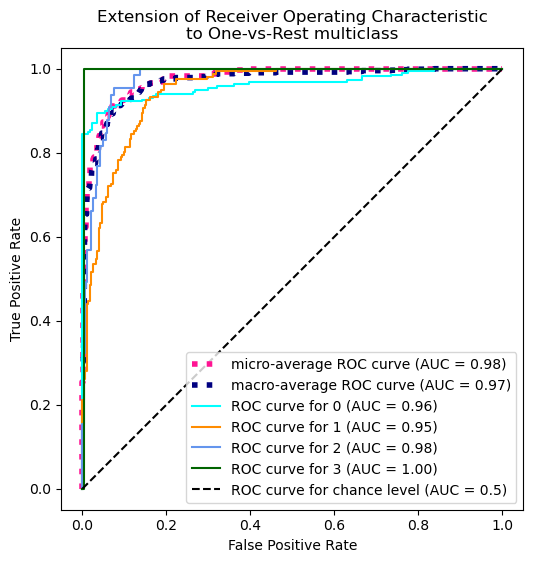

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "darkgreen"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

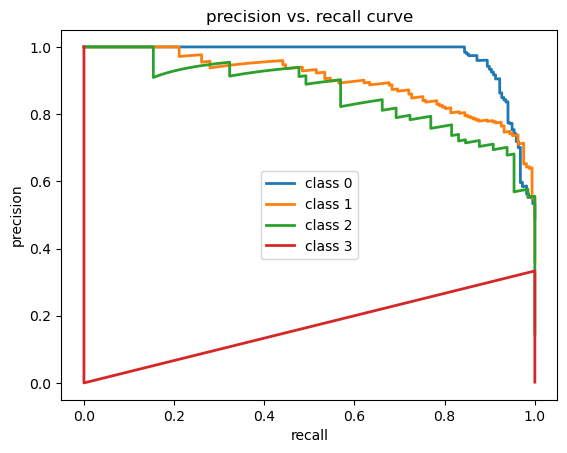

In [54]:
from sklearn.metrics import precision_recall_curve, roc_curve
n_classes=4
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_onehot_test[:, i],y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

